In [1]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person
from tqdm import tqdm
import json
import tensorflow as tf
import numpy as np
sys.path.append("../")
from utils import prewhiten, l2_normalize
from attacks.attack import Attacker
from sklearn.metrics import pairwise_distances, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
seaborn.set()

## Set Up, Load Model, and Images

In [2]:
model_path = '/home/ivan/pascal_adversarial_faces/keras-facenet/model/facenet_keras.h5'

In [3]:
auth_file = "/home/ivan/azure_auth.json"
with open(auth_file, "r") as f:
    auth_data = json.loads(f.read())
face_client = FaceClient(
    auth_data["endpoint"], 
    CognitiveServicesCredentials(auth_data["key"])
)

In [4]:
model = tf.keras.models.load_model(model_path)

In [5]:
def load_image_for_vggface(
    path,
    crop_box,
    resize_size=160,
    prewhiten=False
):
    img = Image.open(path).convert("RGB").crop(crop_box).resize((resize_size, resize_size))
    img = (np.array(img)).astype(np.float32)
    
    if prewhiten:
        img = prewhiten(img)
    
    return img

def load_cropped_images(paths_list):
    final_imgs = []
    for img_path in paths_list:
        results = face_client.face.detect_with_stream(
            open(img_path, "r+b"), 
            detectionModel='detection_02'
        )
        crop_box = (
            results[0].face_rectangle.left,
            results[0].face_rectangle.top,
            results[0].face_rectangle.left + results[0].face_rectangle.width,
            results[0].face_rectangle.top + results[0].face_rectangle.height
        )
        final_imgs.append(load_image_for_vggface(img_path, crop_box))
        
    mean, std = np.mean(final_imgs), np.std(final_imgs)
    final_imgs = prewhiten(np.array(final_imgs))
    return final_imgs, mean, std


In [6]:
yoshi_paths = glob.glob("/data/ivan_yoshi_pascal/yoshi_*")
ivan_paths = glob.glob("/data/ivan_yoshi_pascal/ivan_*")

In [7]:
yoshi_images, yoshi_mean, yoshi_std = load_cropped_images(yoshi_paths)

In [8]:
ivan_images, ivan_mean, ivan_std = load_cropped_images(ivan_paths)

In [9]:
def roc_curve(positive, negative):
    roc_auc = roc_auc_score(
        [1 for x in positive] + [0 for x in negative],
        np.concatenate((positive, negative), axis=0), 
    )
    print(f"Computed ROC AUC: {roc_auc:.3f}")
    
    thresholds = np.arange(1e-6, 2.0, 0.1)
    tprs = []
    fprs = []
    n_pos = float(len(positive))
    n_neg = float(len(negative))

    print("**** Computing ROC curve *****")
    for t in thresholds:
        tp = np.sum(positive < t)
        fp = np.sum(negative < t)
        tprs.append(tp / n_pos)
        fprs.append(fp / n_neg)

    plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")
    plt.plot(fprs, tprs, label="ResNet50 VGGFace2")
    plt.legend()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve for model")

In [10]:
def undo_preprocess(images, mean, std):
    restored_images = images.copy()
    restored_images  *= std
    restored_images += mean
    restored_images = np.clip(restored_images, 0.0, 255.0)
    return np.uint8(restored_images)

## Sanity Check Model Loading

In [12]:
def sanity_check(model, ivan_images, yoshi_images):
    yoshi_embeddings = model.predict(np.array(yoshi_images), batch_size=6)
    yoshi_embeddings = l2_normalize(yoshi_embeddings)
    
    ivan_embeddings = model.predict(np.array(ivan_images), batch_size=6)
    ivan_embeddings = l2_normalize(ivan_embeddings)
    
    self_distances = pairwise_distances(
         ivan_embeddings,
         ivan_embeddings,
         metric='euclidean',
         n_jobs=4
    )
    # all distances below the diagonal compare every pair and exclude 0's to self
    self_dist_indices = np.tril_indices(n=len(ivan_embeddings), k=-1)
    # this selection returns a flattened array of distances that are ground truth True
    self_distances = self_distances[self_dist_indices]

    negative_distances = pairwise_distances(
        ivan_embeddings,
        yoshi_embeddings,
        metric='euclidean',
        n_jobs=4
    ).flatten()

    roc_curve(self_distances, negative_distances)

Computed ROC AUC: 0.013
**** Computing ROC curve *****


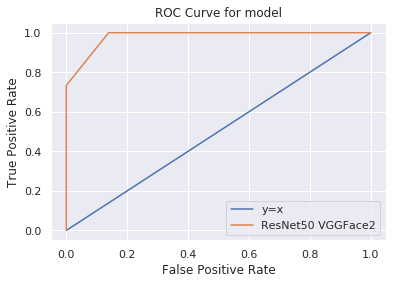

In [13]:
sanity_check(model, ivan_images, yoshi_images)

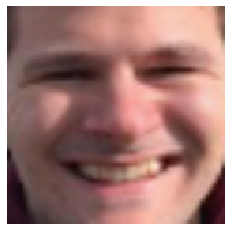

In [14]:
plt.axis('off')
plt.imshow(undo_preprocess(ivan_images[0], ivan_mean, ivan_std))

## Attack Experiments

In [34]:
class ExperimentalAttacker(Attacker):
    def _get_default_kwargs(self, kwargs, image_batch):
        """
        Gets some default values for existing hyper-parameters.
        """
        if 'bounds' not in kwargs:
            kwargs['bounds'] = [tf.reduce_min(image_batch), tf.reduce_max(image_batch)]
        if 'num_iters' not in kwargs:
            kwargs['num_iters'] = 400
        if 'patience' not in kwargs:
            kwargs['patience'] = 5
        if 'alpha' not in kwargs:
            kwargs['alpha'] = 0.001
        if 'verbose' not in kwargs:
            kwargs['verbose'] = False
        return kwargs


    def target_vector_attack(
        self, 
        image_batch, 
        target_embedding, 
        normalize_target_embedding=True, 
        epsilon=0.1, 
        **kwargs
    ):
        """
        Attacks a batch of images using PGD using the
        target-image strategy.
        Args:
            image_batch: A batch of images. The images to perturb.
            target_embedding: the target embeddings to send adversarial images to
            normalize_target_embedding: if True, l2 normalizes the target_embedding
            epsilon: Maximum perturbation amount
            kwargs: Varies depending on attack.
        """
        kwargs = self._get_default_kwargs(kwargs, image_batch)
        image_batch  = tf.convert_to_tensor(image_batch.copy())
        target_embedding = tf.convert_to_tensor(target_embedding, dtype=tf.float32)
        
        if normalize_target_embedding:
            target_embedding = self._l2_normalize(target_embedding)
        
        perturbed_image_batch = image_batch

        previous_difference = np.inf
        best_perturbation = perturbed_image_batch
        patience_count = 0

        iterable = range(kwargs['num_iters'])
        if kwargs['verbose']:
            iterable = tqdm(iterable)
        
        losses = []
        for i in iterable:
            with tf.GradientTape() as tape:
                tape.watch(perturbed_image_batch)
                
                batch_input_to_model = tf.image.random_flip_left_right(perturbed_image_batch)
                batch_input_to_model = tf.image.random_brightness(batch_input_to_model, max_delta=0.25)
#                 batch_input_to_model = tf.image.random_jpeg_quality(batch_input_to_model, 5, 90)

                batch_input_to_model += tf.random.normal(batch_input_to_model.shape, 0.0, 0.5)
    
                batch_embedding = self.model(batch_input_to_model)
        
                batch_embedding = self._l2_normalize(batch_embedding)
                difference = self._l2_distance(target_embedding, batch_embedding)
                mean_difference = tf.reduce_mean(difference)
                
                losses.append(mean_difference)
                
            if mean_difference < previous_difference:
                previous_difference = mean_difference
                best_perturbation = perturbed_image_batch
#                 patience_counnt = 0
#             elif patience_count >= kwargs['patience']:
#                 break
#             else:
#                 patience_count += 1

            gradient = tape.gradient(difference, perturbed_image_batch)
            sign_of_gradient = tf.cast(tf.sign(gradient), perturbed_image_batch.dtype)

            # Subtract the gradient because we want to minimize the distance
            perturbed_image_batch = perturbed_image_batch - sign_of_gradient * kwargs['alpha']
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, image_batch - epsilon, image_batch + epsilon)
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, kwargs['bounds'][0], kwargs['bounds'][1])

        return best_perturbation, losses

In [28]:
yoshi_embeddings = model.predict(np.array(yoshi_images), batch_size=6)

In [35]:
attacker = ExperimentalAttacker(model)
ivan_adversairal_img, losses = attacker.target_vector_attack(
    ivan_images[0:1], 
    yoshi_embeddings[0:1],
    normalize_target_embedding=True, 
    num_iters=1000
)

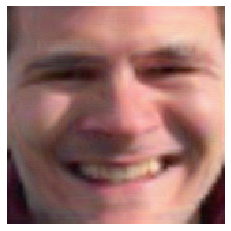

In [36]:
plt.axis("off")
plt.imshow(undo_preprocess(np.array(ivan_adversairal_img[0]), ivan_mean, ivan_std))

In [37]:
plt.plot(range(losses), losses)

TypeError: 'list' object cannot be interpreted as an integer